**박보현**

***Fashion MNIST 데이터셋 이용하여 이미지 생성 (GAN) ***

 - GAN 코드에 Fashion MNIST 데이터셋 적용하여 실습


In [ ]:
# 라이브러리
import torch
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
# 하이퍼파라미터 설정
latent_size = 64
hidden_size = 256
image_size = 784 # 28 * 28
num_epochs = 300
batch_size = 100

# **데이터 준비**

In [ ]:
# Image Processing
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], # 1 for gray scale 만약, RGB channels라면 mean=(0.5, 0.5, 0.5)
                                         std=[0.5])])  # 1 for gray scale 만약, RGB channels라면 std=(0.5, 0.5, 0.5)

# MNIST dataset
mnist_train = datasets.FashionMNIST(root='MNIST_data/',
                          train=True,
                          transform=transform,
                          download=True)

mnist_test = datasets.FashionMNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms,
                         download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16669767.37it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265722.11it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4958231.97it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13614298.23it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



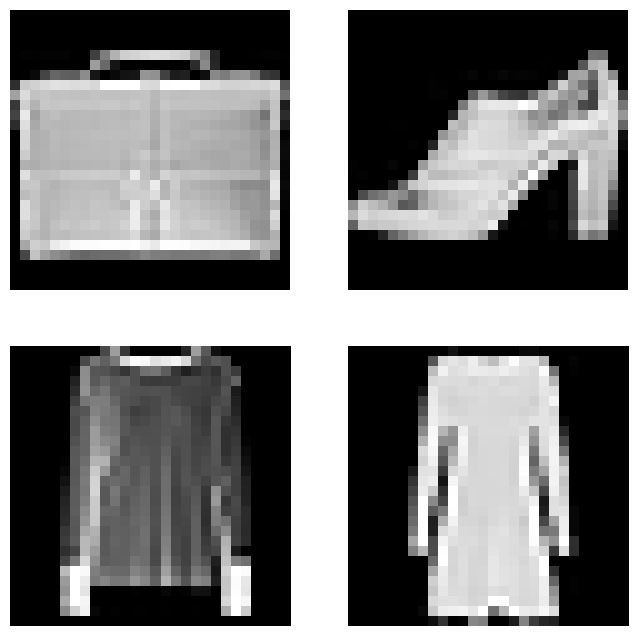

In [ ]:
# 랜덤으로 4개만 시각화
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off") # x축, y축 안보이게 설정
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# 데이터 로더
data_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# **신경망 구성**

In [ ]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()) # Binary Cross Entropy loss 를 사용할 것이기에 sigmoid 사용!

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# **학습**

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad(): # 가중치를 0으로 초기화
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
dx_epoch = []
dgx_epoch = []
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    dx_epoch.append(real_score.mean().item())
    dgx_epoch.append(fake_score.mean().item())
    # real image 저장
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # 생성된 이미지 저장
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 생성자, 판별자 각각 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/300], Step [200/600], d_loss: 0.0640, g_loss: 4.0232, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1585, g_loss: 6.2025, D(x): 0.94, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0993, g_loss: 4.2209, D(x): 0.95, D(G(z)): 0.03
Epoch [1/300], Step [200/600], d_loss: 0.0285, g_loss: 4.5230, D(x): 1.00, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0564, g_loss: 4.5778, D(x): 0.98, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.0244, g_loss: 6.1583, D(x): 0.99, D(G(z)): 0.01
Epoch [2/300], Step [200/600], d_loss: 0.0112, g_loss: 7.1496, D(x): 0.99, D(G(z)): 0.00
Epoch [2/300], Step [400/600], d_loss: 0.0910, g_loss: 6.4564, D(x): 0.97, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0828, g_loss: 7.6933, D(x): 0.97, D(G(z)): 0.01
Epoch [3/300], Step [200/600], d_loss: 0.0847, g_loss: 7.3317, D(x): 0.99, D(G(z)): 0.06
Epoch [3/300], Step [400/600], d_loss: 0.0146, g_loss: 5.6906, D(x): 1.00, D(G(z)): 0.01
Epoch [3/300], Step [

# **테스트**

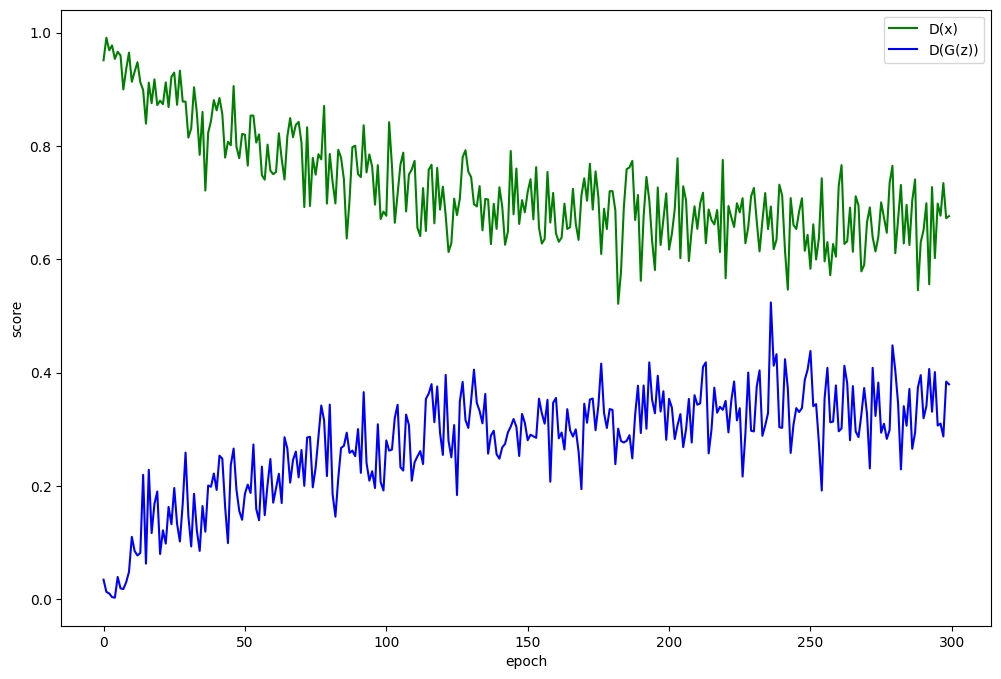

In [ ]:
# plot
plt.figure(figsize = (12, 8))
plt.xlabel('epoch')
plt.ylabel('score')
x = np.arange(num_epochs)
plt.plot(x, dx_epoch, 'g', label='D(x)')
plt.plot(x, dgx_epoch, 'b', label='D(G(z))')
plt.legend()
plt.show()